In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/microsoft-stock-time-series-analysis/Microsoft_Stock.csv


In [3]:
import pandas as pd

# Load the data
df = pd.read_csv('/kaggle/input/microsoft-stock-time-series-analysis/Microsoft_Stock.csv', parse_dates=['Date'])

# Set 'Date' column as the index
df.set_index('Date', inplace=True)

# Make them pure dates
df.index = df.index.date

# Display the first few rows
print(df.head())


             Open   High    Low  Close    Volume
2015-04-01  40.60  40.76  40.31  40.72  36865322
2015-04-02  40.66  40.74  40.12  40.29  37487476
2015-04-06  40.34  41.78  40.18  41.55  39223692
2015-04-07  41.61  41.91  41.31  41.53  28809375
2015-04-08  41.48  41.69  41.04  41.42  24753438


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1511 entries, 2015-04-01 to 2021-03-31
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1511 non-null   float64
 1   High    1511 non-null   float64
 2   Low     1511 non-null   float64
 3   Close   1511 non-null   float64
 4   Volume  1511 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 70.8+ KB


In [7]:
# 1. compute min/max for all numeric columns
summary = df.agg(['min', 'max'])

# 2. grab the min/max of the Date index
min_date, max_date = df.index.min(), df.index.max()

# 3. add them into the summary as a new column
summary['Date'] = [min_date, max_date]

print(summary)


       Open    High     Low   Close     Volume        Date
min   40.34   40.74   39.72   40.29     101612  2015-04-01
max  245.03  246.13  242.92  244.99  135227059  2021-03-31


Line chart of closing prices

<Axes: title={'center': 'MSFT Closing Price'}>

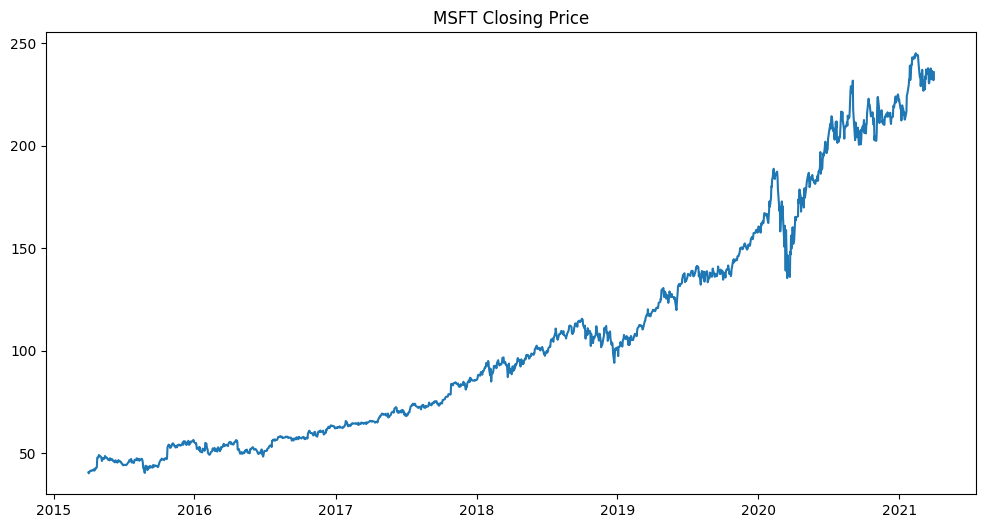

In [8]:
df['Close'].plot(figsize=(12,6), title="MSFT Closing Price")

Candlestick (OHLC) chart

In [9]:
import mplfinance as mpf
mpf.plot(df, type='candle', volume=True, title="MSFT OHLC & Volume")

ModuleNotFoundError: No module named 'mplfinance'